## 贝叶斯推理网络简介
贝叶斯推理网络（Bayesian Belief Network，BBN）是一种概率图模型，用于表示变量之间的依赖关系，并利用贝叶斯推理进行推断。它通常用于处理不确定性问题，特别是在面对大量不确定性信息时，如医学诊断、风险评估、决策支持等领域。

BBN主要由两部分组成：节点（Nodes）和边（Edges）。节点表示随机变量，边表示节点之间的依赖关系。节点之间的依赖关系通过条件概率分布（Conditional Probability Distribution）表示，即给定其父节点的条件下，每个节点的概率分布。

在贝叶斯推理网络中，可以通过观察一些节点的取值，推断其他节点的可能取值，这是通过贝叶斯定理进行的。贝叶斯推理网络的一大优势是能够有效地处理不确定性，并且能够自然地表示因果关系和条件依赖关系。

## 通过MindSpore Quantum实现贝叶斯推理
量子比特本身就包含概率的信息，量子门也可以自然地表示节点之间的约束关系，我们可以考虑用量子电路的方式实现贝叶斯网络并且展示其推理，概率更新，接受或者拒绝，结果选择（测量）等功能。接下来展示如何使用 Mindspore Quantum 搭建量子电路实现对贝叶斯网络推理。

### 创建经典知识库 (Classical Knowledge Base, KB)

考虑如下的贝叶斯网络

![image.png](image.png)

这个网络描述了一个简单的医疗诊断贝叶斯网络，涉及吸烟、支气管炎、肺癌、X射线检查和呼吸困难（Dyspnea）之间的关系。
接下来以经典数据类型给出这些规则和知识

In [278]:
nodes_info = {
    'Smoking': [],
    'Bronchitis': ['Smoking'],
    'LungCancer': ['Smoking'],
    'XRay': ['Smoking', 'LungCancer'],
    'Dyspnea': ['Bronchitis', 'LungCancer']
}
CPD_info = {
    'Smoking': [0.5],
    'Bronchitis': [0.1, 0.6],
    'LungCancer': [0.01, 0.1],
    'XRay': [0.98, 0.05, 0.9, 0.2],
    'Dyspnea': [0.9, 0.7, 0.8, 0.1]
}


CPD_info中的各个键值对应于每个节点的条件概率分布（Conditional Probability Distribution）。例如，对于节点'Smoking'，CPD_info['Smoking'] = [0.5] 表示在没有其他信息的情况下，有50%的概率某人吸烟，这是一个先验分布。

对于其他受约束的节点，例如节点 'XRay'，其父节点是 'Smoking' 和 'LungCancer'，所以条件概率分布的顺序是：<br>
 ['Smoking=No,LungCancer=No', 'Smoking=No,LungCancer=Yes', 'Smoking=Yes,LungCancer=No', 'Smoking=Yes,LungCancer=Yes']<br>
 对应着四种情况下进行X射线检查的结果的概率。

将以上数据封装为 **经典知识库 (Classical Knowledge Base, KB)**

In [279]:
class Classic_BayesianNetwork:
    def __init__(self, nodes_info, CPD_info):
        self.node_count = len(nodes_info)
        self.nodes_info = nodes_info
        self.CPD_info = CPD_info
KB = Classic_BayesianNetwork(nodes_info, CPD_info)

接下来创建量子推理引擎 (Quantum Inference Engine, QIE)，并将经典的网络信息编码成量子电路

导入 mindspore quantum 量子计算库

In [280]:
from mindquantum import *

将网络中的节点用量子比特模拟：

In [281]:
n_qubits = KB.node_count
qubits = list(KB.nodes_info.keys())
sim = Simulator('mqvector',n_qubits)

设置电路，并且初始化先验分布

In [282]:
circ = Circuit()
def set_initial_state():
    for i in range(n_qubits):
        circ.h(i)
    sim.apply_circuit(circ)
set_initial_state()

这里设置所有事件发生概率都为 50%

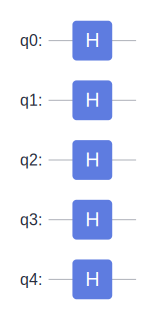

In [283]:
circ.svg()

根据节点的约束关系 (CPD) 添加受控门和旋转门

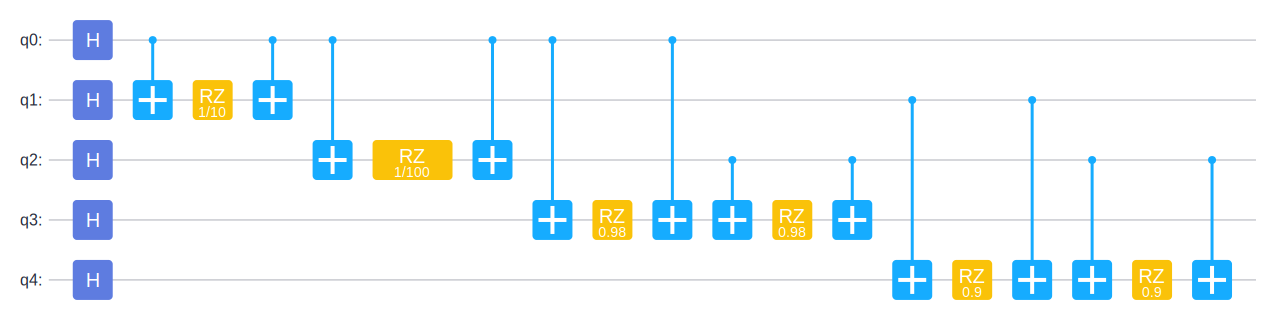

In [284]:
prg = PRGenerator('alpha')
def build_CPD(node,circ):
    for parent in KB.nodes_info[node]:
        circ.x(qubits.index(node), qubits.index(parent))
        circ += RZ(KB.CPD_info[node][0]).on(qubits.index(node))   
        circ.x(qubits.index(node), qubits.index(parent))
for node in KB.nodes_info:
    build_CPD(node,circ)

circ.svg()
    

网络构建完成，运行电路查看状态

In [285]:
sim.get_qs(True)

'√2/8¦00000⟩\n√2/8¦00001⟩\n√2/8¦00010⟩\n√2/8¦00011⟩\n√2/8¦00100⟩\n√2/8¦00101⟩\n√2/8¦00110⟩\n√2/8¦00111⟩\n√2/8¦01000⟩\n√2/8¦01001⟩\n√2/8¦01010⟩\n√2/8¦01011⟩\n√2/8¦01100⟩\n√2/8¦01101⟩\n√2/8¦01110⟩\n√2/8¦01111⟩\n√2/8¦10000⟩\n√2/8¦10001⟩\n√2/8¦10010⟩\n√2/8¦10011⟩\n√2/8¦10100⟩\n√2/8¦10101⟩\n√2/8¦10110⟩\n√2/8¦10111⟩\n√2/8¦11000⟩\n√2/8¦11001⟩\n√2/8¦11010⟩\n√2/8¦11011⟩\n√2/8¦11100⟩\n√2/8¦11101⟩\n√2/8¦11110⟩\n√2/8¦11111⟩'

可以对特定节点进行测量得到发生的概率

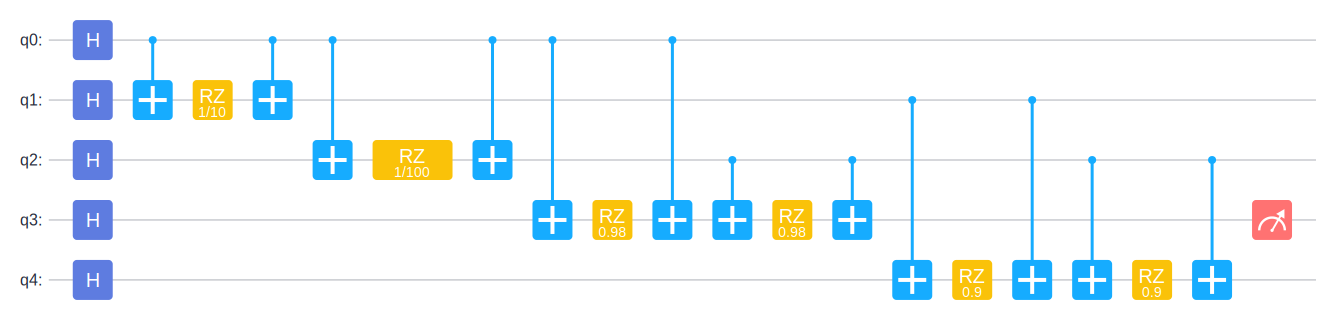

In [286]:
def measure(node,circ):
    circ+=Measure(node).on(qubits.index(node))
    result = sim.sampling(circ, shots=1000)
    return result
result = measure('XRay',circ)
circ.svg()


In [287]:
result

shots: 1000
Keys: XRay│0.00     0.2         0.4         0.6         0.8         1.0
──────────┼───────────┴───────────┴───────────┴───────────┴───────────┴
         0│▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓
          │
{'0': 1000}

也可以对一些假设进行验证，从而判断是否接受。
比如说验证命题 : 不抽烟更容易得肺癌。

In [288]:
#验证命题 : 不抽烟更容易得肺癌。
def is_dont_smoke_easier_to_get_lung_cancer(circ):
    sim.reset()
    circ = Circuit()
    build_CPD('LungCancer',circ)
    result_smoke = measure('LungCancer',circ)
    return result_smoke.shots<100
is_dont_smoke_easier_to_get_lung_cancer(circ)
    

False

### 概率更新：

当发现验证命题的结果和实际情况不符的时候，可能要考虑更新先验分布或者各边的权重：

In [289]:
def update(circ,Assert,truth):
    res = Assert(circ)
    if res == truth:
        return True
    else:
        #调整边的权重
        KB.CPD_info.update()
        set_initial_state()
        return False

然后运行电路继续验证和调整

In [290]:
while True:
    if not update(circ,is_dont_smoke_easier_to_get_lung_cancer,True):
        break
    

## 总结

至此，我们用在 mindspore quantum 平台上通过量子电路的方式构建了贝叶斯网络推理的框架，实现了网络的推理，判断对命题接受或者拒绝，对结果进行选择（测量），概率更新等功能。